<a href="https://colab.research.google.com/github/Manditar2/NLI-con-red-neuronal-LSTM/blob/main/Proyecto_data_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from keras.layers import Input, Embedding, LSTM , Dense, Flatten, Dropout , GRU, TimeDistributed, Conv1D, MaxPool1D
from keras.metrics import TruePositives, FalsePositives,categorical_accuracy, TrueNegatives, FalseNegatives, Precision, Recall, AUC



In [2]:
nltk.download('stopwords')
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--2023-05-29 13:05:26--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-29 13:05:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.03MB/s    in 2m 39s  

2023-05-29 13:08:06 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [3]:
#@title Cargar datos
df = pd.read_csv('/content/sample_data/snli_1.0_train.csv')
columnas = ['sentence1','sentence2','gold_label']
df = df[columnas]
df.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df.head()

,sentence1,sentence2,gold_label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,neutral
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",contradiction
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",entailment
3,Children smiling and waving at camera,They are smiling at their parents,neutral
4,Children smiling and waving at camera,There are children present,entailment


In [4]:
df = df.loc[df['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df = df.loc[df['gold_label'] != "neutral"]
df.shape

(35787, 3)

In [5]:
df = df.sample(frac = 1)
df["gold_label"] = (df["gold_label"] == "contradiction").astype(int)
df.head()

,sentence1,sentence2,gold_label
50574,A child rides a bike high in the air.,A child riding a bike.,0
16594,A lot of motorcycles lined up in Asia.,There are a few motorcycles in Asia.,1
23954,A group of hikers in packs walk up a stone sta...,A group of hikers are outside.,0
22515,A man in a black shirt is throwing a child in ...,A man wearing clothes throwing a child into th...,0
7999,Some youth are playing basketball on an outdoo...,The youth are playing basketball.,0


In [6]:
y = df['gold_label']
len(df)
X = df[['sentence1','sentence2']]

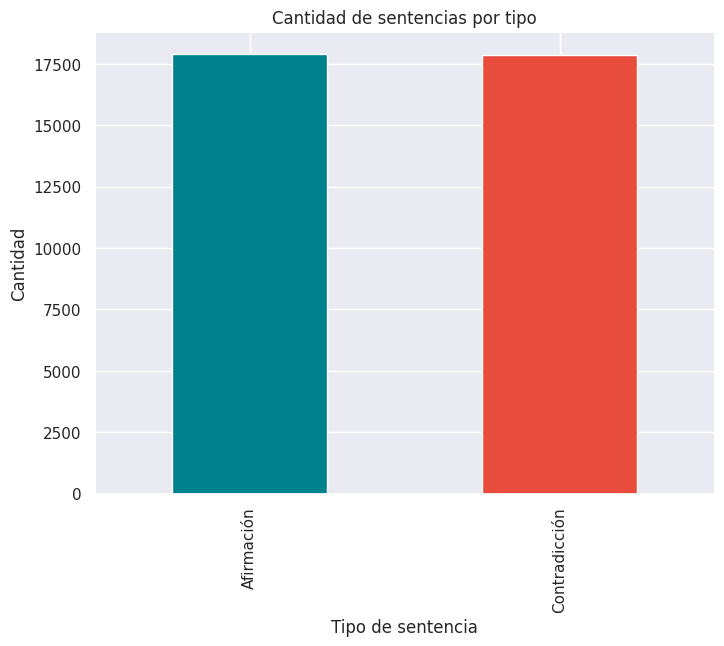

In [7]:
sns.set(style='darkgrid')
colores = ['#00818E', '#e74c3c']
counts = df['gold_label'].value_counts().rename({0: 'Afirmación', 1: 'Contradicción'})

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color = colores)
plt.title('Cantidad de sentencias por tipo')
plt.xlabel('Tipo de sentencia')
plt.ylabel('Cantidad')
plt.show()

In [8]:
#@title Limpieza de datos

def limpiarTexto(sentences):
  # texto = str(texto).lower()
  # texto = re.sub('\[.*?\]', '', texto)
  # texto = re.sub('<.*?>+', '', texto)
  # texto = re.sub('\n', '', texto)
  # texto = re.sub('[%s]' % re.escape(string.punctuation), '', texto)
  # texto = re.sub('\w*\d\w*', '', texto)
  # return texto
  sentences = sentences.apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])
  sentences = sentences.apply(lambda wrd: ''.join(wrd))
  sentences = sentences.apply(lambda sequence:
                                            [word for word in sequence.split() if word not in stop_words])
  sentences = sentences.apply(lambda wrd: ' '.join(wrd))
  return sentences
df.head()

,sentence1,sentence2,gold_label
50574,A child rides a bike high in the air.,A child riding a bike.,0
16594,A lot of motorcycles lined up in Asia.,There are a few motorcycles in Asia.,1
23954,A group of hikers in packs walk up a stone sta...,A group of hikers are outside.,0
22515,A man in a black shirt is throwing a child in ...,A man wearing clothes throwing a child into th...,0
7999,Some youth are playing basketball on an outdoo...,The youth are playing basketball.,0


In [11]:
# df['sentence1'] = df['sentence1'].apply(limpiarTexto)
# df['sentence2'] = df['sentence2'].apply(limpiarTexto)
stop_words = stopwords.words('english')
limpiarTexto(df['sentence1'])
limpiarTexto(df['sentence2'])
df.head()

,sentence1,sentence2,gold_label
50574,A child rides a bike high in the air.,A child riding a bike.,0
16594,A lot of motorcycles lined up in Asia.,There are a few motorcycles in Asia.,1
23954,A group of hikers in packs walk up a stone sta...,A group of hikers are outside.,0
22515,A man in a black shirt is throwing a child in ...,A man wearing clothes throwing a child into th...,0
7999,Some youth are playing basketball on an outdoo...,The youth are playing basketball.,0


In [ ]:
#@title Pre procesamiento
# stop_words = stopwords.words('english')
# more_stopwords = ['u', 'im', 'c']
# stop_words = stop_words + more_stopwords

# def remove_stopwords(text):
#     text = ' '.join(word for word in text.split(' ') if word not in stop_words)
#     return text
  
# df['sentence1'] = df['sentence1'].apply(remove_stopwords)
# df['sentence2'] = df['sentence2'].apply(remove_stopwords)
# df['sentence1'].shape
# df['sentence2'].shape


In [ ]:
# stemmer = nltk.SnowballStemmer('english')
# def stematizar(texto):
#   texto = ' '.join(stemmer.stem(word) for word in texto.split(' ')) #Divide el texto, y aplica la función de stematización a cada palabra
#   return texto
# df['sentence1'] = df['sentence1'].apply(stematizar)
# df['sentence2'] = df['sentence2'].apply(stematizar)
# df.head()


In [12]:
df['sentence1'].shape
df['sentence2'].shape

(35787,)

In [13]:
#@title Tokenización
sentencias_arreglo = np.asarray([df['sentence1'],df['sentence2']])
print(sentencias_arreglo)
sentencias_arreglo = sentencias_arreglo.reshape(-1,1)

[['A child rides a bike high in the air.'
  'A lot of motorcycles lined up in Asia.'
  'A group of hikers in packs walk up a stone staircase in the forest.'
  ... 'A blond woman is playing drums with band members.'
  'The teddy bear has white pads on the bottom of its feet.'
  'A man riding his bike looking ahead at finish line.']
 ['A child riding a bike.' 'There are a few motorcycles in Asia.'
  'A group of hikers are outside.' ... 'A kid playing his guitar.'
  'The teddy bear has brown pads on its paws' 'A man is in a race.']]


In [14]:
sentencias_arreglo.shape

(71574, 1)

In [15]:
print(sentencias_arreglo)

[['A child rides a bike high in the air.']
 ['A lot of motorcycles lined up in Asia.']
 ['A group of hikers in packs walk up a stone staircase in the forest.']
 ...
 ['A kid playing his guitar.']
 ['The teddy bear has brown pads on its paws']
 ['A man is in a race.']]


In [16]:
sentencias_arreglo = sentencias_arreglo.reshape(sentencias_arreglo.shape[0])
sentencias_arreglo.shape

(71574,)

In [17]:
print(sentencias_arreglo)

['A child rides a bike high in the air.'
 'A lot of motorcycles lined up in Asia.'
 'A group of hikers in packs walk up a stone staircase in the forest.' ...
 'A kid playing his guitar.' 'The teddy bear has brown pads on its paws'
 'A man is in a race.']


In [18]:
tokenizar = Tokenizer(num_words = 6000)
tokenizar.fit_on_texts(sentencias_arreglo) #Transforma a "número" las palabras dentro del arreglo


In [19]:
texto_original_seq = tokenizar.texts_to_sequences(df['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original = pad_sequences(texto_original_seq) #Agrega padding para estandarizar el tamaño
hipotesis_seq = tokenizar.texts_to_sequences(df['sentence2'])
hipotesis = pad_sequences(hipotesis_seq, maxlen = texto_original.shape[1])
print(hipotesis)

[[   0    0    0 ...   61    1   84]
 [   0    0    0 ...  581    3 1650]
 [   0    0    0 ...  771    7   33]
 ...
 [   0    0    0 ...   19   18  130]
 [   0    0    0 ...    6  208 4242]
 [   0    0    0 ...    3    1  187]]


In [20]:
encoder = LabelEncoder()
etiquetas = df['gold_label']
etiquetas = encoder.fit_transform(etiquetas)
etiquetas

array([0, 1, 0, ..., 1, 1, 0])

In [21]:
etiquetas = to_categorical(etiquetas)
etiquetas

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [22]:
texto_original.shape

(35787, 78)

In [23]:
hipotesis.shape

(35787, 78)

In [24]:
data_tokenizada = np.asarray([texto_original,hipotesis])
data_tokenizada

array([[[   0,    0,    0, ...,    3,    2,  129],
        [   0,    0,    0, ...,   53,    3, 1650],
        [   0,    0,    0, ...,    3,    2,  429],
        ...,
        [   0,    0,    0, ...,   10,  176,  833],
        [   0,    0,    0, ...,    9,  208,  519],
        [   0,    0,    0, ...,   15, 1472,  288]],

       [[   0,    0,    0, ...,   61,    1,   84],
        [   0,    0,    0, ...,  581,    3, 1650],
        [   0,    0,    0, ...,  771,    7,   33],
        ...,
        [   0,    0,    0, ...,   19,   18,  130],
        [   0,    0,    0, ...,    6,  208, 4242],
        [   0,    0,    0, ...,    3,    1,  187]]], dtype=int32)

In [25]:
data_tokenizada.shape

(2, 35787, 78)

In [26]:
data_tokenizada = data_tokenizada.reshape(data_tokenizada.shape[1], 2, data_tokenizada.shape[2])

In [27]:
data_tokenizada.shape

(35787, 2, 78)

In [28]:
tokenizar.word_index

{'a': 1,
 'the': 2,
 'in': 3,
 'is': 4,
 'man': 5,
 'on': 6,
 'are': 7,
 'and': 8,
 'of': 9,
 'with': 10,
 'woman': 11,
 'people': 12,
 'two': 13,
 'to': 14,
 'at': 15,
 'an': 16,
 'wearing': 17,
 'his': 18,
 'playing': 19,
 'men': 20,
 'shirt': 21,
 'young': 22,
 'girl': 23,
 'white': 24,
 'sitting': 25,
 'black': 26,
 'dog': 27,
 'blue': 28,
 'while': 29,
 'boy': 30,
 'standing': 31,
 'red': 32,
 'outside': 33,
 'group': 34,
 'her': 35,
 'person': 36,
 'street': 37,
 'walking': 38,
 'down': 39,
 'there': 40,
 'three': 41,
 'holding': 42,
 'front': 43,
 'by': 44,
 'women': 45,
 'one': 46,
 'for': 47,
 'child': 48,
 'water': 49,
 'their': 50,
 'looking': 51,
 'children': 52,
 'up': 53,
 'green': 54,
 'some': 55,
 'as': 56,
 'running': 57,
 'little': 58,
 'yellow': 59,
 'has': 60,
 'riding': 61,
 'near': 62,
 'through': 63,
 'other': 64,
 'large': 65,
 'hat': 66,
 'next': 67,
 'ball': 68,
 'from': 69,
 'out': 70,
 'another': 71,
 'brown': 72,
 'beach': 73,
 'building': 74,
 'into': 75,


In [29]:
#@title Embedding
vocabulario = len(tokenizar.word_index)

def gloveWork(archivo,vocabulario):
  #Se crea un diccionario palabra-vector de un modelo preentrenado(Glove)
  embeddings_index = {}
  file_ = open(archivo)
  for line in file_:
      arr = line.split()
      palabra = arr[0]
      vector = np.asarray(arr[1:],dtype='float32')
      embeddings_index[palabra] = vector
  file_.close() 

  tam_maximo = vocabulario +1
  indices_palabras = tokenizar.word_index
  embedding_matriz = np.zeros((tam_maximo,300)).astype(object)

  for palabrax, indice in indices_palabras.items():
    vector_entrenado = embeddings_index.get(palabrax)
    if vector_entrenado is not None:
      embedding_matriz[indice] = vector_entrenado

  return embedding_matriz


In [30]:
#@title Modelo
x = Input(shape=(data_tokenizada.shape[1], data_tokenizada.shape[2],))
p = TimeDistributed(Embedding(vocabulario + 1 , 300))(x)
p = TimeDistributed(LSTM(128, return_sequences=True))(p)
p = TimeDistributed(LSTM(64, return_sequences=True))(p)
x1 = TimeDistributed(tf.keras.layers.GlobalMaxPooling1D())(p)
x2 = TimeDistributed(tf.keras.layers.GlobalAveragePooling1D())(p)
concat = tf.keras.layers.concatenate([x1, x2])
p = tf.keras.layers.Dropout(0.3)(concat)
p = Flatten()(p)
p = Dense(2, activation="softmax")(p)

In [31]:
m = tf.keras.models.Model(inputs = x, outputs = p)

In [32]:
m.layers[1].set_weights([gloveWork("glove.6B.300d.txt", vocabulario)])

In [33]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 78)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 2, 78, 300)  3264000     ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 2, 78, 128)  219648      ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

In [34]:
m.compile(loss="binary_crossentropy",optimizer='adam',metrics=[TruePositives(name='tp'),
                                                                     FalsePositives(name='fp'),
                                                                     TrueNegatives(name='tn'),
                                                                     FalseNegatives(name='fn'),
                                                                     "accuracy",
                                                                     Precision(name='precision'),
                                                                     Recall(name='recall'),
                                                                     AUC(name = "AUC")])


In [35]:
earlyStopping = EarlyStopping(monitor = 'loss', patience = 60, mode = 'min', restore_best_weights = True)

In [ ]:
history_training = m.fit(data_tokenizada,etiquetas,
                         epochs= 2500,
                         batch_size = 1024,
                         use_multiprocessing=True,
                         workers=-1,
                         callbacks=[earlyStopping])

Epoch 1/2500
35/35 [==============================] - 158s 4s/step - loss: 0.6937 - tp: 17859.0000 - fp: 17928.0000 - tn: 17859.0000 - fn: 17928.0000 - accuracy: 0.4990 - precision: 0.4990 - recall: 0.4990 - AUC: 0.4968
Epoch 2/2500
35/35 [==============================] - 149s 4s/step - loss: 0.6929 - tp: 18196.0000 - fp: 17591.0000 - tn: 18196.0000 - fn: 17591.0000 - accuracy: 0.5085 - precision: 0.5085 - recall: 0.5085 - AUC: 0.5137
Epoch 3/2500
35/35 [==============================] - 147s 4s/step - loss: 0.6921 - tp: 18579.0000 - fp: 17208.0000 - tn: 18579.0000 - fn: 17208.0000 - accuracy: 0.5192 - precision: 0.5192 - recall: 0.5192 - AUC: 0.5284
Epoch 4/2500
35/35 [==============================] - 153s 4s/step - loss: 0.6909 - tp: 19025.0000 - fp: 16762.0000 - tn: 19025.0000 - fn: 16762.0000 - accuracy: 0.5316 - precision: 0.5316 - recall: 0.5316 - AUC: 0.5409
Epoch 5/2500
35/35 [==============================] - 149s 4s/step - loss: 0.6871 - tp: 19487.0000 - fp: 16300.0000 - tn

In [ ]:
import matplotlib as mpl
def draw_plot(data,c, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (20, 6))
  plt.plot(data,c, label= type_data)
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()


In [ ]:
draw_plot(history_training.history['accuracy'],"darkgreen", "Precisión")

In [ ]:

draw_plot(history_training.history['loss'],"blue", "Pérdida")

In [ ]:
draw_plot(history_training.history['fn'],'blue','prueba')

In [ ]:
#@title Cargar datos de prueba
df_prueba = pd.read_csv('/content/sample_data/snli_1.0_test.csv')
columnas_prueba = ['sentence1','sentence2','gold_label']
df_prueba = df_prueba[columnas_prueba]
df_prueba.dropna(axis=0, inplace=True) #Se eliminan datos nulos
df_prueba.head()

In [ ]:
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "-"]   #Se botan las filas que contengan - y neutral
df_prueba = df_prueba.loc[df_prueba['gold_label'] != "neutral"]
df_prueba.shape

In [ ]:
df_prueba = df_prueba.sample(frac = 1)
df_prueba["gold_label"] = (df_prueba["gold_label"] == "contradiction").astype(int)
df_prueba.head()

In [ ]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(limpiarTexto)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(limpiarTexto)
df_prueba.head()

In [ ]:
df_prueba['sentence1'] = df_prueba['sentence1'].apply(remove_stopwords)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(remove_stopwords)
df_prueba['sentence1'] = df_prueba['sentence1'].apply(stematizar)
df_prueba['sentence2'] = df_prueba['sentence2'].apply(stematizar)

In [ ]:
#@title Tokenización set de pruebas
sentencias_arreglo_prueba = np.asarray([df_prueba['sentence1'],df_prueba['sentence2']])
print(sentencias_arreglo_prueba)
sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(-1,1)
sentencias_arreglo_prueba = sentencias_arreglo_prueba.reshape(sentencias_arreglo_prueba.shape[0])
texto_original_seq_prueba = tokenizar.texts_to_sequences(df_prueba['sentence1']) #Guarda un arreglo que en vez de palabras, posee índices de palabras
texto_original_prueba = pad_sequences(texto_original_seq_prueba,45) #Agrega padding para estandarizar el tamaño
hipotesis_seq_prueba = tokenizar.texts_to_sequences(df_prueba['sentence2'])
hipotesis_prueba = pad_sequences(hipotesis_seq_prueba, maxlen = texto_original_prueba.shape[1])
hipotesis_prueba.shape

In [ ]:
texto_original_prueba.shape

In [ ]:
tokenizar.word_index

In [ ]:
encoder_prueba = LabelEncoder()
etiquetas_prueba = df_prueba['gold_label']
etiquetas_prueba = encoder_prueba.fit_transform(etiquetas_prueba)
etiquetas_prueba = to_categorical(etiquetas_prueba)
etiquetas_prueba.shape

In [ ]:
data_tokenizada_prueba = np.asarray([texto_original_prueba,hipotesis_prueba])
data_tokenizada_prueba = data_tokenizada_prueba.reshape(data_tokenizada_prueba.shape[1], 2, data_tokenizada_prueba.shape[2])
data_tokenizada_prueba.shape

In [ ]:
m.evaluate(data_tokenizada_prueba,etiquetas_prueba,batch_size = 6605)

In [ ]:

from sklearn.metrics import accuracy_score


In [ ]:
prediccion = m.predict(data_tokenizada_prueba, batch_size = 1024, verbose = 1)
prediccion